In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_moons

%matplotlib inline

# K-means

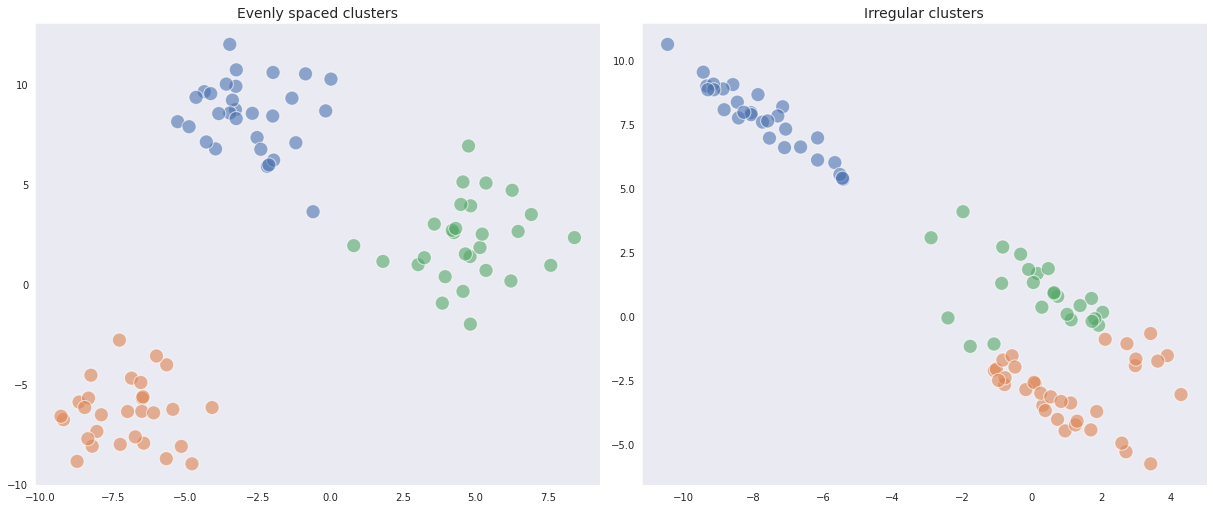

In [182]:
X, y = make_blobs(n_samples=87, cluster_std=[1.6, 2.0, 1.5], random_state=42)
X_aniso = np.matmul(X, [[0.6, -0.3], [-0.7, 0.8]]) # anisotropicly distributed data

kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
kmeans_aniso = KMeans(n_clusters=3, random_state=42).fit(X_aniso)

with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(17, 7))
plt.tight_layout()
ax[0].set_title('Evenly spaced clusters', fontsize=14)
sns.scatterplot(x=X[:, 0], y=X[:, 1], 
                hue=kmeans.labels_, palette='deep', alpha=0.6, ax=ax[0], legend=False, s=200)
ax[1].set_title('Irregular clusters', fontsize=14)
sns.scatterplot(x=X_aniso[:, 0], y=X_aniso[:, 1], 
                hue=kmeans_aniso.labels_, palette='deep', alpha=0.6, ax=ax[1], legend=False, s=200)

plt.savefig('../../assets/images/clustering/K_means_clustering.png', bbox_inches='tight');

# Agglomerative

## With dendrogram

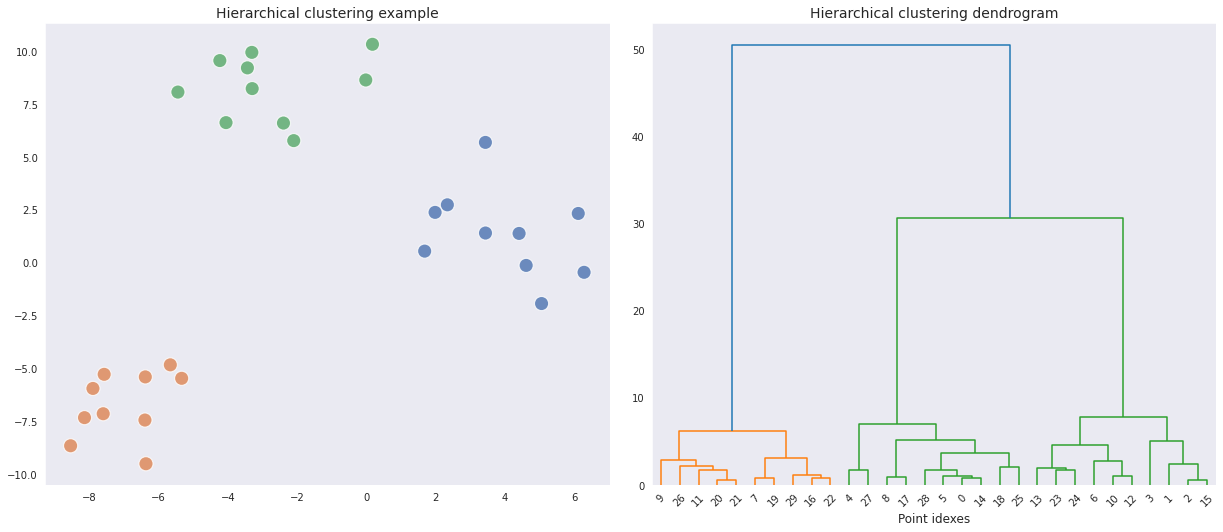

In [44]:
X, y = make_blobs(n_samples=30, cluster_std=[1.7, 2.0, 1.5], random_state=42)

def plot_dendrogram(model, **kwargs):
    '''Creates linkage matrix from the passed model and then plots the dendrogram'''
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
model = AgglomerativeClustering(n_clusters=3, linkage='ward', compute_distances=True)
model = model.fit(X)
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(17, 7))
plt.tight_layout()
ax[0].set_title('Hierarchical clustering example', fontsize=14)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=model.labels_, palette='deep', alpha=0.8, ax=ax[0], legend=False, s=200)

ax[1].set_title('Hierarchical clustering dendrogram', fontsize=14)
plot_dendrogram(model, truncate_mode=None, ax=ax[1])
ax[1].set_xlabel('Point idexes', fontsize=12)
plt.savefig('../../assets/images/clustering/agglomerative_clustering.png', bbox_inches='tight');

## Different types of linkage

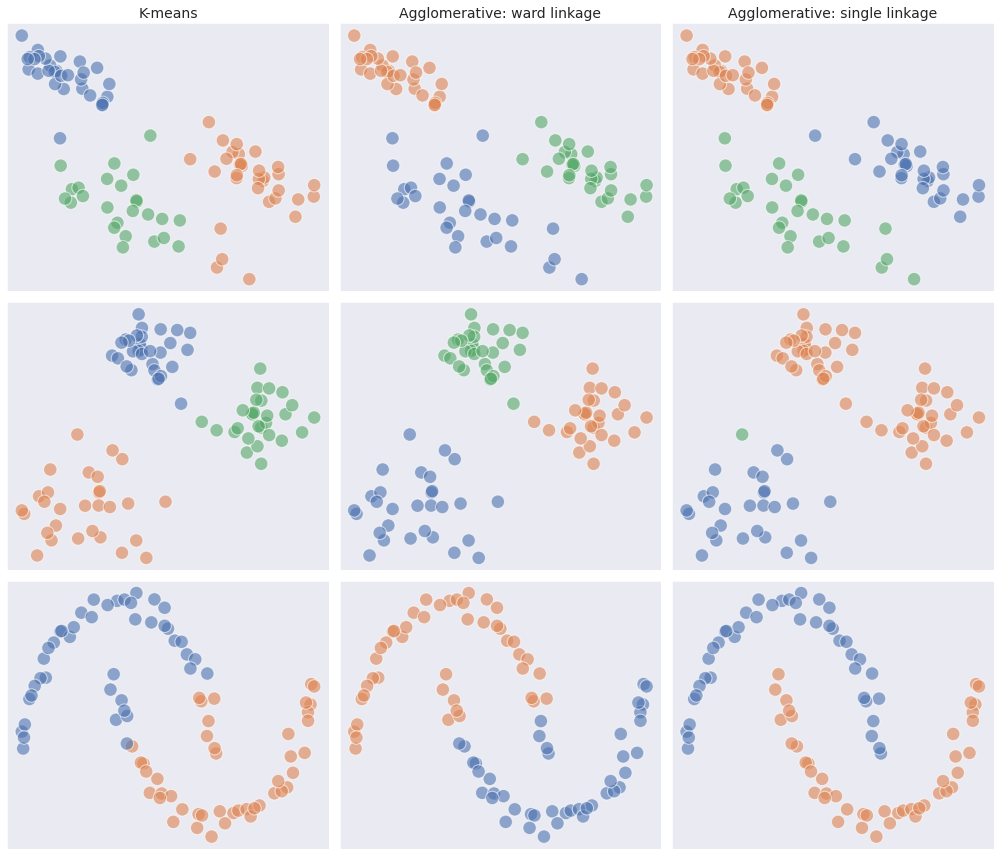

In [11]:
# generate data
n_samples = 87
random_state=42
samples_blobs = make_blobs(n_samples=n_samples, cluster_std=[1.6, 2.0, 2.8], random_state=random_state)[0]
samples_aniso = np.matmul(samples_blobs, [[0.7, -0.3], [-0.4, 0.8]]) # anisotropicly distributed data
samples_moons = make_moons(n_samples=n_samples, noise=.05, random_state=random_state)[0]
datasets = (samples_aniso, samples_blobs, samples_moons)

# create model objects
obj_kmeans = KMeans(n_clusters=3, random_state=42)
obj_aggl_single = AgglomerativeClustering(n_clusters=3, linkage='single')
obj_aggl_ward = AgglomerativeClustering(n_clusters=3, linkage='ward')
models = (
    ('K-means', obj_kmeans),
    ('Agglomerative: ward linkage', obj_aggl_ward),
    ('Agglomerative: single linkage', obj_aggl_single)
)

# plotting
plt.figure(figsize=(14, 12))
plot_num = 1
with sns.axes_style('dark'):
    for i_dataset, dataset in enumerate(datasets):
        dataset = StandardScaler().fit_transform(dataset)
        for model in models:
            plt.subplot(len(datasets), len(models), plot_num)
            if i_dataset == 0:
                plt.title(model[0], fontsize=14) # titles only on top
            if i_dataset == 2:
                model[1].n_clusters = 2 # set two clusters for moons dataset
            model[1].fit(dataset)
            sns.scatterplot(x=dataset[:, 0], y=dataset[:, 1], hue=model[1].labels_,
                            palette='deep', alpha=0.6, legend=False, s=180)
            frame = plt.gca()
            frame.axes.get_xaxis().set_visible(False)
            frame.axes.get_yaxis().set_visible(False)
            
            plot_num += 1
plt.tight_layout()    
plt.savefig('../../assets/images/clustering/agglomerative_linkage_comparison.png', bbox_inches='tight');